# Evolutionary Strategy

In [1]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device", device)

Using device cuda


In [29]:
from collections.abc import Callable
from tqdm.auto import tqdm


def evolutionary_strategy(
        problem: Callable[[torch.Tensor], float],
        dim: int = 10,
        search_boundary: tuple = (-5, 5),
        n_generations: int = 200,
        n_parents: int = 10,
        n_offspring: int = 40,
        step_size: float = 0.1,
        plus_strategy: bool = True,
        maximize: bool = False) -> dict:
    """Simple Evolutionary Strategy (ES) implementation."""

    lower, upper = search_boundary

    # Randomly initialize population
    parents = torch.rand((n_parents, dim)) * (upper - lower) + lower
    fitness = problem(parents)

    best_fitness_history = []
    mean_fitness_history = []

    # === Main loop ===
    for _ in (pbar := tqdm(range(n_generations), desc="ES Progress")):
        # --- Generate λ offspring ---
        parents_indices = torch.randint(0, n_parents, (n_offspring,))
        parent = parents[parents_indices]
        offspring = parent + step_size * torch.randn(n_offspring, dim)
        offspring = torch.clamp(offspring, lower, upper)
        offspring_fitness = problem(offspring)

        # --- Selection ---
        if plus_strategy:
            # (μ + λ)-ES → parents compete with offspring
            combined = torch.vstack((parents, offspring))
            combined_fitness = torch.hstack((fitness, offspring_fitness))
        else:
            # (μ, λ)-ES → only offspring survive
            combined = offspring
            combined_fitness = offspring_fitness

        idx = torch.argsort(combined_fitness, descending=maximize)
        parents = combined[idx[:n_parents]]
        fitness = combined_fitness[idx[:n_parents]]

        best_fitness_history.append(torch.min(fitness))
        mean_fitness_history.append(torch.mean(fitness))

        pbar.set_postfix({
            "best_fitness": best_fitness_history[-1].item(),
            "mean_fitness": mean_fitness_history[-1].item()
        })

    # Return best solution found
    if maximize:
        best_idx = torch.argmax(fitness)
    else:
        best_idx = torch.argmin(fitness)

    return {
        "best_solution": parents[best_idx],
        "best_fitness": fitness[best_idx],
        "fitness_history": {
            "best": best_fitness_history,
            "mean": mean_fitness_history
        }
    }

In [35]:
from objective_functions import sphere, rastrigin, rosenbrock, ackley, schwefel, griewank, levy


objective_functions = {
    "sphere": {
        "function": sphere,
        "search_boundary": (-5, 5),
        "solution": None
    },
    "rastrigin": {
        "function": rastrigin,
        "search_boundary": (-5.12, 5.12),
        "solution": None
    },
    "rosenbrock": {
        "function": rosenbrock,
        "search_boundary": (-2, 2),
        "solution": None
    },
    "ackley": {
        "function": ackley,
        "search_boundary": (-10, 10),
        "solution": None
    },
    "schwefel": {
        "function": schwefel,
        "search_boundary": (-500, 500),
        "solution": None
    },
    "griewank": {
        "function": griewank,
        "search_boundary": (-100, 100),
        "solution": None
    },
    "levy": {
        "function": levy,
        "search_boundary": (-10, 10),
        "solution": None
    }
}

for name, obj in objective_functions.items():
    obj["solution"] = evolutionary_strategy(
        problem=obj["function"],
        dim=10,
        search_boundary=obj["search_boundary"],
        n_generations=5000,
        n_parents=100,
        n_offspring=800,
        step_size=0.5,
        plus_strategy=True,
        maximize=False
    )


ES Progress:   0%|          | 0/5000 [00:00<?, ?it/s]

ES Progress:   0%|          | 0/5000 [00:00<?, ?it/s]

ES Progress:   0%|          | 0/5000 [00:00<?, ?it/s]

ES Progress:   0%|          | 0/5000 [00:00<?, ?it/s]

ES Progress:   0%|          | 0/5000 [00:00<?, ?it/s]

ES Progress:   0%|          | 0/5000 [00:00<?, ?it/s]

ES Progress:   0%|          | 0/5000 [00:00<?, ?it/s]

=== SPHERE FUNCTION ===
Best solution found: tensor([-0.0313,  0.0374, -0.0644, -0.0200, -0.0880,  0.0379,  0.0395, -0.0856,
         0.0606,  0.0996])
Best solution fitness: tensor(0.0386)



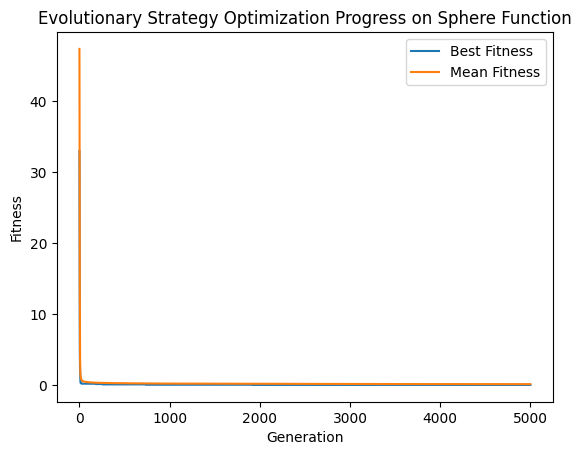

=== RASTRIGIN FUNCTION ===
Best solution found: tensor([ 0.0648,  1.9752, -0.0163, -0.9208, -1.1009, -0.0767,  0.0103,  0.0782,
        -0.9445, -0.9533])
Best solution fitness: tensor(15.2952)



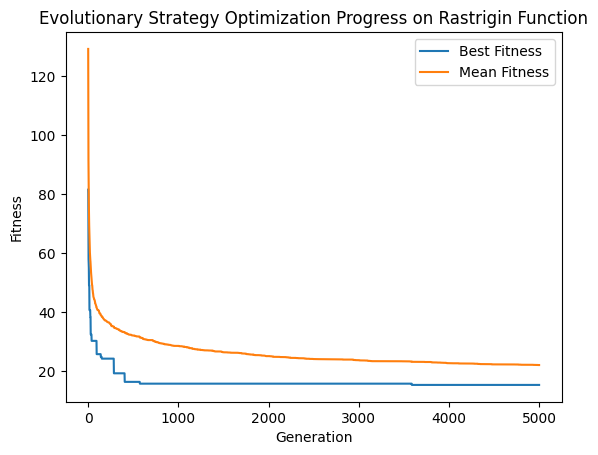

=== ROSENBROCK FUNCTION ===
Best solution found: tensor([ 0.9480,  0.8029,  0.6538,  0.4733,  0.1633,  0.0576,  0.1346, -0.0516,
         0.0526, -0.0842])
Best solution fitness: tensor(9.5951)



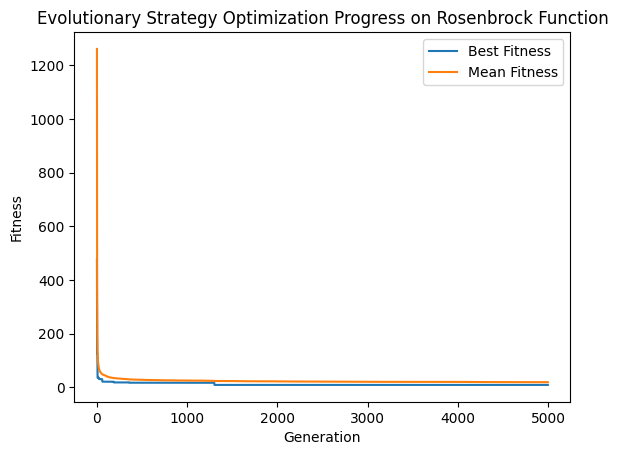

=== ACKLEY FUNCTION ===
Best solution found: tensor([-0.0725,  0.1012,  0.0705,  0.0223, -0.0377, -0.0898,  0.0222, -0.1215,
         0.0672, -0.0167])
Best solution fitness: tensor(0.5327)



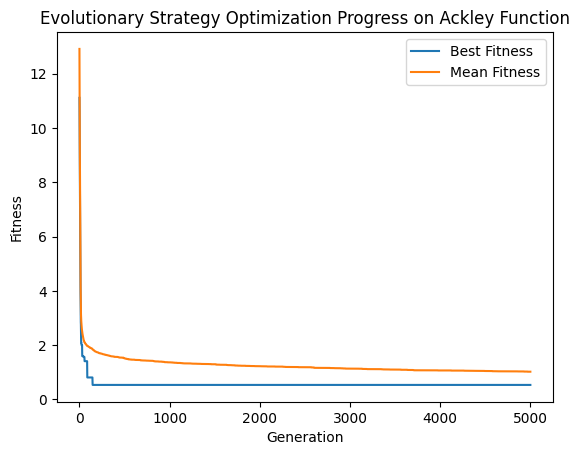

=== SCHWEFEL FUNCTION ===
Best solution found: tensor([-124.7162,  203.7920,  421.1857,  420.9517,  -25.8274, -124.8012,
         -25.8684,  420.9897,  421.0173,  -25.9162])
Best solution fitness: tensor(1994.0618)



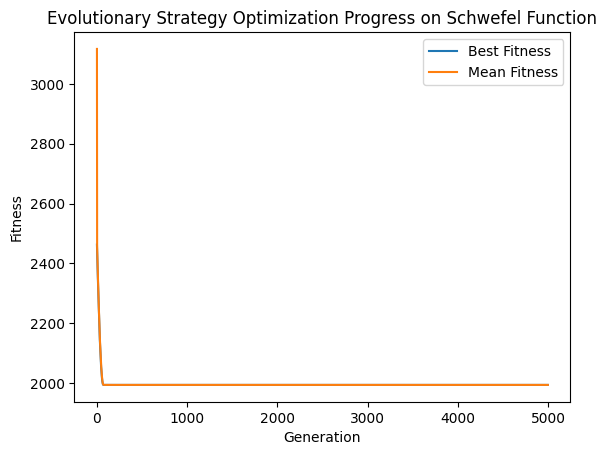

=== GRIEWANK FUNCTION ===
Best solution found: tensor([ 2.5172e+01,  8.8625e+00,  5.4362e+01,  6.2728e+01, -3.5048e+01,
        -1.5311e+01, -1.6333e+01,  8.6425e+00,  1.8681e+01, -2.7144e-03])
Best solution fitness: tensor(2.4539)



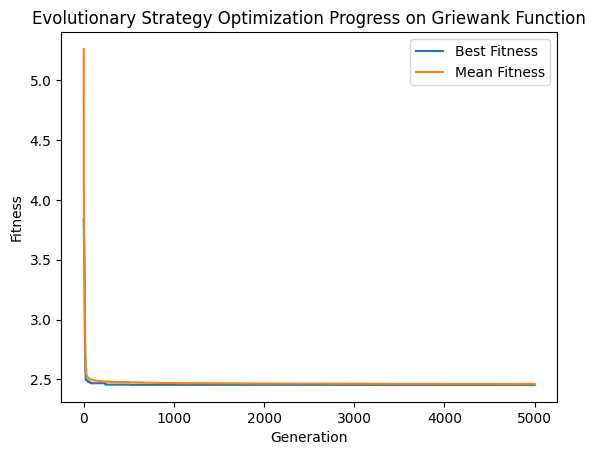

=== LEVY FUNCTION ===
Best solution found: tensor([1.0063, 0.9269, 1.0096, 0.9954, 1.0243, 1.1465, 1.0343, 0.9249, 1.0470,
        1.2202])
Best solution fitness: tensor(0.0229)



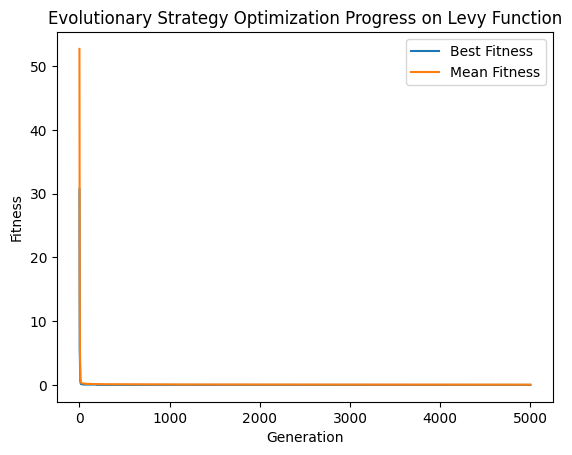

In [36]:
import matplotlib.pyplot as plt


for name, obj in objective_functions.items():
    solution = obj["solution"]
    best_solution, best_fitness, fitness_history = solution["best_solution"], solution["best_fitness"], solution["fitness_history"]
    best_fitness_history = fitness_history["best"]
    mean_fitness_history = fitness_history["mean"]

    print(f"=== {name.upper()} FUNCTION ===")
    print("Best solution found:", best_solution)
    print("Best solution fitness:", best_fitness)
    print()

    plt.plot(best_fitness_history, label="Best Fitness")
    plt.plot(mean_fitness_history, label="Mean Fitness")
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.title(f"Evolutionary Strategy Optimization Progress on {name.capitalize()} Function")
    plt.legend()
    plt.show()

# Very good!